In [1]:
import os
import cobra
import pandas as pd
import numpy as np

import medusa
from medusa.flux_analysis import flux_balance

from pickle import load

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mticker
matplotlib.rcParams["savefig.dpi"] = 300
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
# load all ensembles
ensembles = {}
exclude = ['Bacillus megaterium','Stenotrophomonas maltophilia',
           'Gordonia bronchialis','Achromobacter piechaudii',
          'Achromobacter xylosoxidans']
for species_file in os.listdir("../results/deep_ensembles/"):
    species_name = species_file.split(".")[0]
    
    if species_name not in exclude:
        with open("../results/deep_ensembles/"+species_name+".pickle",'rb') as infile:
            ensembles[species_name] = load(infile)

In [5]:
# get predicted flux through biomass in complete media for all ensembles
bm_flux = {}
for species in ensembles.keys():
    if species not in exclude:
        print("performing ensemble FBA for " + species)
        ensemble = ensembles[species]

        # make sure all exchange reactions are open to calculate
        # growth rate in complete media
        ex_rxns = [rxn for rxn in ensemble.base_model.reactions if
                      rxn.id.startswith('EX_')]
        for rxn in ex_rxns:
            rxn.lower_bound = -1000

        bm_flux[species] = flux_balance.optimize_ensemble(
                                ensemble,
                                return_flux = "bio1"
                                )
        #bm_flux[species].index = [member for member in bm_flux[species].index]

performing ensemble FBA for Ralstonia solanacearum
performing ensemble FBA for Streptococcus oralis
performing ensemble FBA for Listeria monocytogenes
performing ensemble FBA for Streptococcus vestibularis
performing ensemble FBA for Neisseria meningitidis
performing ensemble FBA for Bacillus pumilus
performing ensemble FBA for Ralstonia pickettii
performing ensemble FBA for Flavobacterium johnsoniae
performing ensemble FBA for Aeromonas salmonicida
performing ensemble FBA for Neisseria flavescens
performing ensemble FBA for Haemophilus parasuis
performing ensemble FBA for Streptococcus equinus
performing ensemble FBA for Pseudomonas stutzeri
performing ensemble FBA for Sphingobacterium spiritivorum
performing ensemble FBA for Enterococcus faecalis
performing ensemble FBA for Chryseobacterium gleum
performing ensemble FBA for Streptococcus gallolyticus
performing ensemble FBA for Pseudomonas putida
performing ensemble FBA for Streptococcus mitis
performing ensemble FBA for Staphylococc

In [6]:
# load the gene essentiality predictions for subsampling
gene_knockout_results = {}    
for fname in os.listdir('../results/gene_knockouts/'):
    species = fname.split('.')[0]
    if species not in exclude:
        frame = pd.read_csv(
            '../results/gene_knockouts/'+species+'.csv',sep=',',index_col=0)

        frame = frame < 1E-6
        frame = frame.loc[(frame == 1).sum(axis=1) != len(frame.columns)]
        frame = frame.loc[(frame == 0).sum(axis=1) < len(frame.columns)]
        gene_knockout_results[species] = frame.T

In [7]:
# test out the subsampling approach for genes here... prototype is in the cell below, which might work
# but will have long runtime.
gene_knockout_results[species].sum() > 0 & (gene_knockout_results[species].sum() < len(gene_knockout_results[species].index))

96563.4.peg.3268    True
96563.4.peg.1139    True
96563.4.peg.2233    True
96563.4.peg.1108    True
96563.4.peg.1422    True
96563.4.peg.1029    True
96563.4.peg.624     True
96563.4.peg.3896    True
96563.4.peg.3881    True
96563.4.peg.2428    True
96563.4.peg.3236    True
96563.4.peg.3625    True
96563.4.peg.3329    True
96563.4.peg.2340    True
96563.4.peg.1436    True
96563.4.peg.2115    True
96563.4.peg.2130    True
96563.4.peg.3264    True
96563.4.peg.2736    True
96563.4.peg.4160    True
96563.4.peg.1722    True
96563.4.peg.2202    True
96563.4.peg.495     True
96563.4.peg.3266    True
96563.4.peg.1030    True
96563.4.peg.1965    True
96563.4.peg.463     True
96563.4.peg.34      True
96563.4.peg.597     True
96563.4.peg.3053    True
96563.4.peg.550     True
96563.4.peg.598     True
96563.4.peg.559     True
dtype: bool

In [8]:
# Extract the features and states from the ensemble for subsampling
# at given intervals for n_draws at each interval
interval = 20
subsample_sizes = list(range(interval,1001,interval))
n_draws = 1000
feature_plotframes = {}
bm_flux_mean_plotframes = {}
bm_flux_std_plotframes = {}
gene_plotframes = {}

for species in gene_knockout_results.keys():
    print('Subampling for ' + species)
    ensemble = ensembles[species]
        
    # Grab the features and states for the ensemble and convert to a dataframe
    feature_dict = {}
    for feature in ensemble.features:
        feature_dict[feature.id] = feature.states
    feature_frame = pd.DataFrame.from_dict(feature_dict)

    # Convert to a boolean dataframe for faster computation
    # (0 values become False, all others become True (i.e. active features))
    feature_frame = feature_frame.astype(bool)
    
    counts = {}
    gene_counts = {}
    bm_flux_means = {}
    bm_flux_std = {}
    species_mean = bm_flux[species]['bio1'].mean()
    for sample_size in subsample_sizes:

        # randomly select a number of samples (sample_size) n_draw times
        counts[sample_size] = []
        gene_counts[sample_size] = []
        bm_flux_means[sample_size] = []
        bm_flux_std[sample_size] = []
        for i in range(0,n_draws):
            draw = feature_frame.sample(n=sample_size, replace=True)
            
            # get the number of features with a non-zero entry
            # i.e. those that are active in this subsample
            non_redundant = (draw.sum(axis=0) > 0).sum()
            counts[sample_size].append(non_redundant)
            
            # extract the biomass flux predictions for this draw as well
            bm_flux_sample = bm_flux[species].loc[draw.index,'bio1']
            # normalize the mean/std subsample by the population mean
            bm_flux_means[sample_size].append(bm_flux_sample.mean()/species_mean)
            bm_flux_std[sample_size].append(bm_flux_sample.std()/species_mean)
            
            # extract the gene essentiality predictions from the draw
            gene_sample = gene_knockout_results[species].loc[draw.index]
            # count the number of genes with more than one unique value from the subsample
            gene_counts[sample_size].append(sum(
                (gene_sample.sum()) > 0 & 
                (gene_sample.sum() < len(gene_sample.index))))
            
    # Convert the subsampling results into a dataframe
    counts_frame = pd.DataFrame.from_dict(counts)
    gene_counts_frame = pd.DataFrame.from_dict(gene_counts)
    bm_flux_mean_frame = pd.DataFrame.from_dict(bm_flux_means)
    bm_flux_std_frame = pd.DataFrame.from_dict(bm_flux_std)

    # collapse feature subsampling to mean and standard deviation
    feature_plotframes[species] = pd.DataFrame()
    feature_plotframes[species]['mean'] = counts_frame.mean(axis=0)
    feature_plotframes[species]['standard deviation'] = counts_frame.std(axis=0)
    
    # collapse gene essentiality subsampling to mean and standard deviation
    gene_plotframes[species] = pd.DataFrame()
    gene_plotframes[species]['mean'] = gene_counts_frame.mean(axis=0)
    gene_plotframes[species]['standard deviation'] = gene_counts_frame.std(axis=0)
    
    
    # Do the same for the biomass flux mean/std (Careful -- these
    # are now means of means and means, std of means, means of std, and std of std)
    bm_flux_mean_plotframes[species] = pd.DataFrame()
    bm_flux_mean_plotframes[species]['mean'] = bm_flux_mean_frame.mean(axis=0)
    bm_flux_mean_plotframes[species]['standard_deviation'] = bm_flux_mean_frame.std(axis=0)
    
    bm_flux_std_plotframes[species] = pd.DataFrame()
    bm_flux_std_plotframes[species]['mean'] = bm_flux_std_frame.mean(axis=0)
    bm_flux_std_plotframes[species]['standard_deviation'] = bm_flux_std_frame.std(axis=0)

Subampling for Ralstonia solanacearum
Subampling for Streptococcus oralis
Subampling for Listeria monocytogenes
Subampling for Streptococcus vestibularis
Subampling for Bacillus pumilus
Subampling for Enterococcus faecalis
Subampling for Flavobacterium johnsoniae
Subampling for Aeromonas salmonicida
Subampling for Neisseria flavescens
Subampling for Streptococcus equinus
Subampling for Listeria seeligeri
Subampling for Pseudomonas stutzeri
Subampling for Ralstonia pickettii
Subampling for Corynebacterium glutamicum
Subampling for Chryseobacterium gleum
Subampling for Streptococcus gallolyticus
Subampling for Neisseria mucosa
Subampling for Pseudomonas putida
Subampling for Neisseria meningitidis
Subampling for Staphylococcus aureus
Subampling for Staphylococcus epidermidis
Subampling for Pseudomonas mendocina
Subampling for Streptococcus pneumoniae
Subampling for Haemophilus influenzae
Subampling for Streptococcus mitis
Subampling for Corynebacterium efficiens
Subampling for Sphingobac

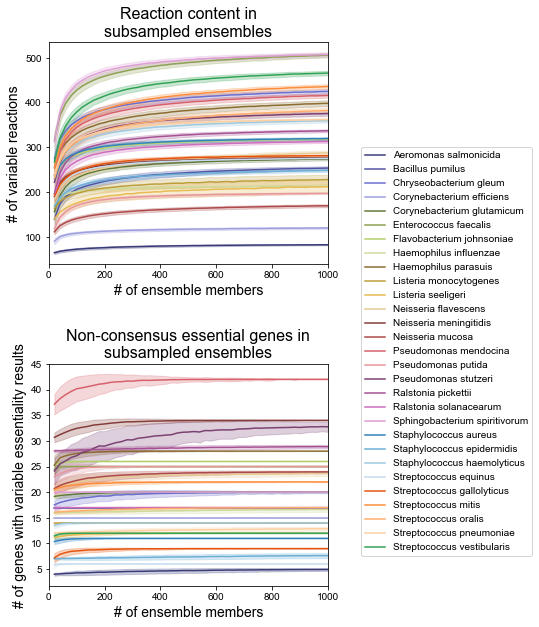

In [31]:

tab20b = matplotlib.cm.get_cmap(name='tab20b', lut=None)
tab20c = matplotlib.cm.get_cmap(name='tab20c', lut=None)        

tableau20 = list(tab20b.colors)
tableau20.extend(list(tab20c.colors))

color_dict = {}
# sort the species names so they are plotted in order by color
species_names = list(feature_plotframes.keys())
species_names = sorted(species_names)
for i in range(0,len(feature_plotframes.keys())):
    color_dict[species_names[i]] = tableau20[i]

fig,ax = plt.subplots(2,1)
for species in species_names:
    plotframe = feature_plotframes[species]
    ax[0].plot(plotframe.index,plotframe['mean'],label=species,color=color_dict[species])
    ax[0].fill_between(plotframe.index,
                plotframe['mean']+plotframe['standard deviation'],
                plotframe['mean']-plotframe['standard deviation'],
               alpha = 0.25,color=color_dict[species])
ax[0].set_title('Reaction content in\nsubsampled ensembles',fontsize=16)
ax[0].set_xlabel('# of ensemble members',fontsize=14)
ax[0].set_ylabel('# of variable reactions',fontsize=14)
ax[0].set_xlim([0,1000])

for species in species_names:
    plotframe = gene_plotframes[species]
    ax[1].plot(plotframe.index,plotframe['mean'],label=species,color=color_dict[species])
    ax[1].fill_between(plotframe.index,
                plotframe['mean']+plotframe['standard deviation'],
                plotframe['mean']-plotframe['standard deviation'],
               alpha = 0.25,color=color_dict[species])
ax[1].set_title('Non-consensus essential genes in\nsubsampled ensembles',fontsize=16)
ax[1].set_xlabel('# of ensemble members',fontsize=14)
ax[1].set_ylabel('# of genes with variable essentiality results',fontsize=14)
ax[1].set_xlim([0,1000])

ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))
ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))
ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))


fig.set_size_inches(5,10)
leg = ax[1].legend(ax[1].get_legend_handles_labels()[0],
          ax[1].get_legend_handles_labels()[1],
          loc='upper left',
          bbox_to_anchor=(1.1,2),
          ncol=1,
          fontsize=10)

fig.subplots_adjust(hspace=0.45)
fig.savefig('../results/ensemble_rxn_gene_subsampling.svg',bbox_inches="tight",bbox_extra_artists=(leg,))
fig.savefig('../results/ensemble_rxn_gene_subsampling.png',bbox_inches="tight",bbox_extra_artists=(leg,))

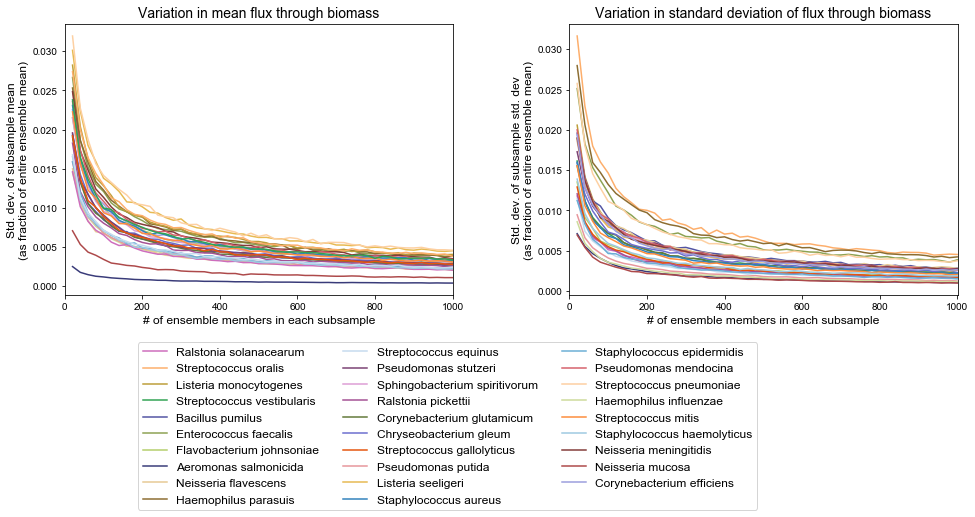

In [12]:
fig,ax = plt.subplots(1,2)
for species in species_names:
    plotframe = bm_flux_mean_plotframes[species]
    ax[0].plot(plotframe.index,plotframe['standard_deviation'], label=species, color=color_dict[species])
ax[0].set_title('Variation in mean flux through biomass',fontsize=14)
ax[0].set_xlabel('# of ensemble members in each subsample',fontsize=12)
ax[0].set_ylabel('Std. dev. of subsample mean\n(as fraction of entire ensemble mean)',fontsize=12)
ax[0].set_xlim([0,1001])

for species in bm_flux_std_plotframes.keys():
    plotframe = bm_flux_std_plotframes[species]
    ax[1].plot(plotframe.index,plotframe['standard_deviation'], label=species, color=color_dict[species])

ax[1].set_title('Variation in standard deviation of flux through biomass',fontsize=14)
ax[1].set_xlabel('# of ensemble members in each subsample',fontsize=12)
ax[1].set_ylabel('Std. dev. of subsample std. dev\n(as fraction of entire ensemble mean)',fontsize=12)
ax[1].set_xlim([0,1001])

ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))
ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))
ax0_legend = dict(zip(ax[0].get_legend_handles_labels()[1],ax[0].get_legend_handles_labels()[0]))


fig.set_size_inches(16,5)
leg = ax[1].legend(ax[1].get_legend_handles_labels()[0],
          ax[1].get_legend_handles_labels()[1],
          loc='upper right',
          bbox_to_anchor=(0.5,-0.15),
          ncol=3,
          fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(bottom=0.5)
fig.subplots_adjust(wspace=0.3)
fig.savefig('../results/ensemble_biomass_subsampling.svg',bbox_inches="tight",bbox_extra_artists=(leg,))
fig.savefig('../results/ensemble_biomass_subsampling.png',bbox_inches="tight",bbox_extra_artists=(leg,))

In [13]:
# Get the summary statistic for number of variable gene essentiality simulation results
n_variable_genes = []
fraction_variable_genes = []
for species in species_names:
    n_genes = len(gene_knockout_results[species].columns)
    n_variable_genes.append(n_genes)
    total_genes = len(ensembles[species].base_model.genes)
    fraction_variable_genes.append(n_genes/total_genes)
print(np.mean(n_variable_genes))
print(np.std(n_variable_genes))
print(np.mean(fraction_variable_genes))
print(np.std(fraction_variable_genes))

19.275862069
8.66581294005
0.0311347797096
0.0139176661794
